In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
dfb6 = pd.read_csv('Data/Building Data/Building 6.csv')

In [3]:
dfb6

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,1,34.6,2019-07-25 02:00:00,2019,7,25,2,0,Building6
1,5,35.2,2019-07-25 03:00:00,2019,7,25,3,0,Building6
2,9,36.0,2019-07-25 04:00:00,2019,7,25,4,0,Building6
3,13,36.0,2019-07-25 05:00:00,2019,7,25,5,0,Building6
4,17,37.0,2019-07-25 06:00:00,2019,7,25,6,0,Building6
...,...,...,...,...,...,...,...,...,...
10585,44613,28.0,2020-10-31 19:00:00,2020,10,31,19,0,Building6
10586,44617,26.8,2020-10-31 20:00:00,2020,10,31,20,0,Building6
10587,44621,25.4,2020-10-31 21:00:00,2020,10,31,21,0,Building6
10588,44625,26.2,2020-10-31 22:00:00,2020,10,31,22,0,Building6


In [6]:
data = dfb6['series_value'][7000:9000]

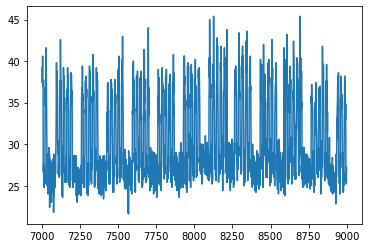

In [7]:
plt.plot(data)

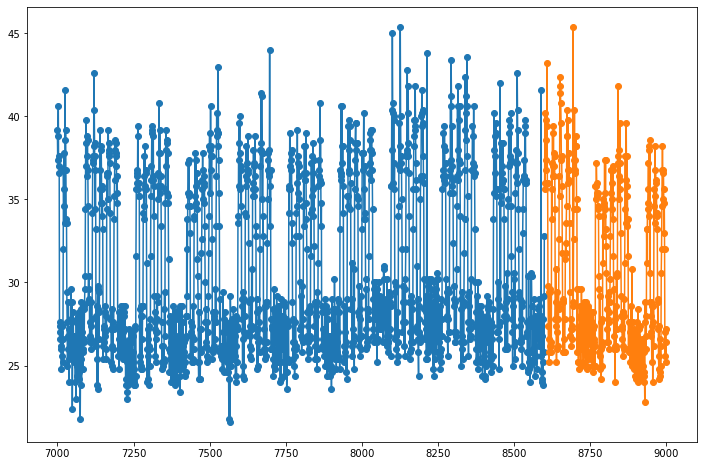

In [8]:
train_size = 0.8

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [9]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1600
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -3807.483
Date:                Tue, 27 Sep 2022   AIC                           7628.966
Time:                        23:30:05   BIC                           7666.610
Sample:                             0   HQIC                          7642.944
                               - 1600                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8805      0.290      9.916      0.000       2.311       3.450
ar.L1          1.2752      0.047     27.404      0.000       1.184       1.366
ar.L2         -0.2082      0.045     -4.622      0.000      -0.297      -0.120
ar.L3          0.1283      0.041      3.138      0.002       0.048       0.208
ar.L4         -0.2900      0.028    -10.458      0.000      -0.344      -0.236
ma.L1         -0.6629      0.047    -14.045      0.000      -0.755      -0.570
sigma2         6.8225      0.181     37.619      0.000       6.467       7.178
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               525.50
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
data = train
# define model
my_order = (4, 1, 1)
my_seasonal_order = (4, 1, 1, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

In [12]:
yhat

7000     0.000000
7001    39.199899
7002    37.399979
7003    38.800049
7004    40.599960
          ...    
7396    25.162240
7397    25.750791
7398    24.695031
7399    27.632349
7400    27.124549
Name: predicted_mean, Length: 401, dtype: float64

In [13]:
lst = []
for i in range(7001, 7401):
    lst.append(yhat[i])

In [14]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [15]:
test

8600    35.6
8601    40.2
8602    36.0
8603    38.6
8604    37.4
        ... 
8995    25.6
8996    27.0
8997    26.4
8998    25.2
8999    27.2
Name: series_value, Length: 400, dtype: float64

In [16]:
lst = []
for i in range(8600, 9000):
    lst.append(test[i])

In [17]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

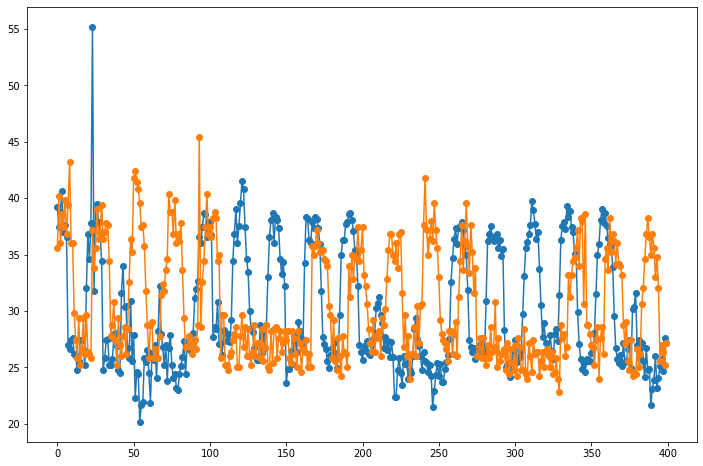

In [18]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [19]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

2.6242076668766123